In [2]:
import psycopg as pg
import networkx as nx
import matplotlib.pyplot as plt
from psycopg.types.enum import EnumInfo, register_enum
from dotenv import load_dotenv

load_dotenv("../.env")

True

NC-f46625accf89581c200940b53bd0b88486451783e92da139cab615241c147167
Source:  57726646 
Target:  57726644 
Edge Type:  EdgeType.Statement 
Direction:  None 
Exception:  None
Source:  57726658 
Target:  57726644 
Edge Type:  EdgeType.Statement 
Direction:  None 
Exception:  None
Source:  57726656 
Target:  57726658 
Edge Type:  EdgeType.Decision 
Direction:  True 
Exception:  None
Source:  57726643 
Target:  57726648 
Edge Type:  EdgeType.Statement 
Direction:  None 
Exception:  None
Source:  57726660 
Target:  57726656 
Edge Type:  EdgeType.Decision 
Direction:  True 
Exception:  None
Source:  57726662 
Target:  57726644 
Edge Type:  EdgeType.Statement 
Direction:  None 
Exception:  None
Source:  57726654 
Target:  57726662 
Edge Type:  EdgeType.Decision 
Direction:  True 
Exception:  None
Source:  57726654 
Target:  57726660 
Edge Type:  EdgeType.Decision 
Direction:  False 
Exception:  None
Source:  57726664 
Target:  57726654 
Edge Type:  EdgeType.Decision 
Direction:  True 
Exceptio

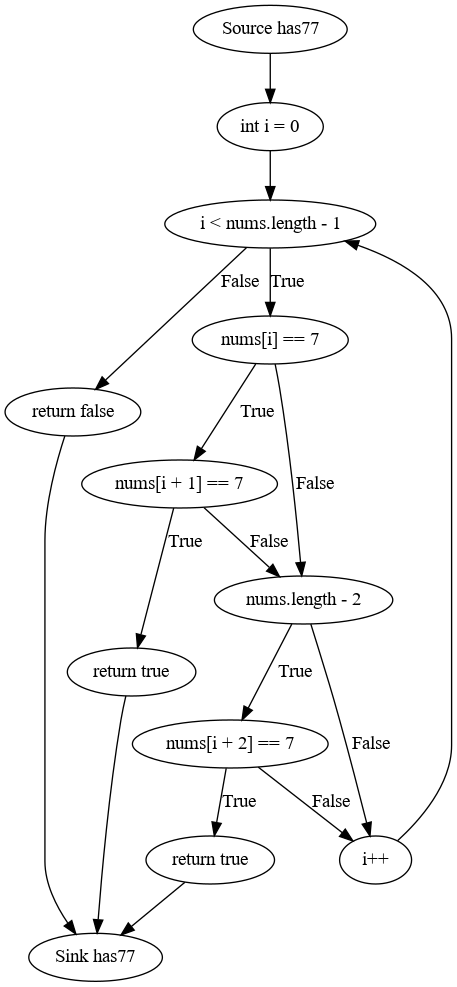

In [5]:
from typing import Optional
from dataclasses import dataclass
from enum import Enum, auto


# noinspection PyArgumentList
class NodeType(Enum):
    Source = auto()
    Sink = auto()
    Statement = auto()
    Control = auto()
    Decision = auto()
    Exception = auto()


# noinspection PyArgumentList
class EdgeType(Enum):
    Statement = auto()
    Decision = auto()
    Exception = auto()


@dataclass
class Node:
    id: int
    node_type: NodeType
    label: Optional[str] = None
    contents: Optional[str] = None

    def __str__(self) -> str:
        return node_data_string(self.node_type, self.label, self.contents)


@dataclass
class Edge:
    source: int
    target: int
    edge_type: EdgeType
    direction: Optional[bool] = None
    exception: Optional[str] = None

    def __str__(self) -> str:
        print(
            "Source: ", self.source,
            "\nTarget: ", self.target,
            "\nEdge Type: ", self.edge_type,
            "\nDirection: ", self.direction,
            "\nException: ", self.exception
        )
        if self.edge_type is EdgeType.Exception:
            return f'{self.exception}'
        elif self.edge_type is EdgeType.Decision:
            return 'True' if self.direction else 'False'
        return ''

@dataclass
class ProgramNode:
    program_id: str
    graph_id: str
    node_type: NodeType
    label: Optional[str] = None
    contents: Optional[str] = None

    def __str__(self) -> str:
        return node_data_string(self.node_type, self.label, self.contents)

def node_data_string(node_type: NodeType, label: Optional[str], contents: Optional[str]):
    match node_type:
        case NodeType.Source:
            return f'Source {contents}'
        case NodeType.Sink:
            return f'Sink {contents}'

    out_label = ''
    if label:
        out_label = f'{label}: '

    out_contents = ''
    if contents:
        out_contents = contents
    return f'{out_label}{out_contents}'
from psycopg.rows import class_row
import pygraphviz as pgv
from IPython.display import Image

graph = nx.MultiDiGraph()
with pg.connect() as conn:
    edge_type_info = EnumInfo.fetch(conn, 'edge_type')
    register_enum(edge_type_info, conn, EdgeType)
    node_type_info = EnumInfo.fetch(conn, 'node_type')
    register_enum(node_type_info, conn, NodeType)
    program_id = conn.execute("SELECT program_id FROM programs ORDER BY random() LIMIT 1").fetchone()[0]
    print(program_id)
    with conn.cursor(row_factory=class_row(Node)) as cursor:
        cursor.execute('''
SELECT
    n.id,
    node_type,
    label,
    contents
FROM
    nodes n
JOIN
    graphs g on g.id = n.graph_id
JOIN
    programs p on g.program_id = p.id
WHERE
    p.program_id = %s
''', (program_id, ))

        for row in cursor.fetchall():
            graph.add_node(row.id, label=str(row))

    with conn.cursor(row_factory=class_row(Edge)) as cursor:
        cursor.execute('''
    SELECT
        source,
        target,
        edge_type,
        direction,
        exception
    FROM
        edges e
    JOIN
        graphs g on g.id = e.graph_id
    JOIN
        programs p on g.program_id = p.id
    WHERE
        p.program_id = %s
    ''', (program_id, ))
        edges = cursor.fetchall()
        for edge in edges:
            graph.add_edge(
                edge.source,
                edge.target,
                label=str(edge)
            )

    print("Graph to train on: ", graph)

for u, v, key, edgedata in graph.edges(data=True, keys=True):
    str_edgedata = {k: str(v) for k, v in edgedata.items() if k != "key"}
    # Add edge data
    print(str_edgedata)
ag = nx.nx_agraph.to_agraph(graph)
print(ag)
Image(ag.draw(format='png', prog='dot'))